In [1]:
#|default_exp challange/ct94ep5

# Cristopher Thomas 94.9% 5 epochs

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from torchvision import transforms

In [3]:
# speed mods
from miniai.utils import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [4]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

## Dropout & Mish

In [5]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [6]:
#| export
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

## CustomDataloader with curriculum learning

In [7]:
torch.topk(torch.randn(5), 5)

torch.return_types.topk(
values=tensor([ 1.69,  0.52,  0.16, -0.51, -0.78]),
indices=tensor([1, 0, 2, 4, 3]))

In [8]:
#|export
def replace_top_losess(n, top_losses, prev_idx):
    num_samples = len(prev_idx)
    top_losses = top_losses.cpu()
    prev_idx = prev_idx.cpu()
    easiest_idx = prev_idx[top_losses[-n:]] 
    hardest_idx = prev_idx[top_losses[:n]]
    indices = torch.arange(num_samples)
    indices[easiest_idx] = hardest_idx
    return indices

In [9]:
top_losses = torch.arange(7)
prev_idx = torch.arange(7).flip(-1)
print(top_losses)
print(prev_idx)
replace_top_losess(3, top_losses, prev_idx)

tensor([0, 1, 2, 3, 4, 5, 6])
tensor([6, 5, 4, 3, 2, 1, 0])


tensor([4, 5, 6, 3, 4, 5, 6])

In [37]:
#|export
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

class TopLossesCallback(Callback):
    def __init__(self, n=None):
        self.epoch_preds = []
        self.epoch_targets = []
        self.n = n or {
            0: 0,
            1: 0.21,
            2: 0.42,
            3: 0.21,
            4: 0
        }
        
    def before_fit(self, learn):
        self.epoch_preds = []
        self.epoch_targets = []

    @torch.no_grad()
    def _calculate_top_losses(self):
        preds = torch.cat(self.epoch_preds, dim=0)
        targets = torch.cat(self.epoch_targets, dim=0)
        losses = F.cross_entropy(preds, targets, reduce=False)
        return torch.topk(losses, preds.shape[0]).indices
    
    def after_batch(self, learn):
        if learn.training: 
            self.epoch_preds.append(learn.preds)
            self.epoch_targets.append(learn.batch[1])
            
    def before_epoch(self,learn):
        mix_precentage = self.n.get(learn.epoch,0)
        learn.dls.train.sampler.mix_precentage = self.n.get(learn.epoch,0)
        #print("setting epoch", learn.epoch)
        
    def after_epoch(self, learn):
        if self.epoch_preds:
            #print("after epoch", len(self.epoch_targets))
            learn.dls.train.sampler.top_losses = self._calculate_top_losses()
            self.epoch_preds = []
            self.epoch_targets = []
        
# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.
class CustomTrainingSampler(WeightedRandomSampler):
    def __init__(self, *args, **kwargs):
        WeightedRandomSampler.__init__(self, *args, **kwargs)
        self.data_indexes_for_epoch = torch.randperm(self.num_samples, generator=self.generator)
        self.top_losses = self.data_indexes_for_epoch.clone()
        self.mix_precentage = 0 

    def setup_epoch(self, mix_precentage=None):
        rand_tensor = torch.randperm(self.num_samples, generator=self.generator)
        n = int((mix_precentage or self.mix_precentage) * self.num_samples)
        if n != 0:
            print(f"Replacing top {n} expamples out of {self.num_samples}")
            new_idx = replace_top_losess(n, self.top_losses, self.data_indexes_for_epoch)
            self.data_indexes_for_epoch = new_idx[rand_tensor]
        else:
            self.data_indexes_for_epoch = rand_tensor

            
    def __iter__(self) -> Iterator[int]:
        self.setup_epoch(None)
        yield from self.data_indexes_for_epoch

class CustomDataLoader:
    def __init__(self, *dls): 
        self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
        if mode != "train": return None
        return CustomTrainingSampler(weights=[1.0]*num_samples, num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, **kwargs):
        return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) 
                     for mode, ds in dd.items()])

In [28]:
# lets test that sampler is working
s = CustomTrainingSampler([1]*5, num_samples=5)
s.epoch=1
list(s), s.data_indexes_for_epoch

([tensor(2), tensor(1), tensor(0), tensor(3), tensor(4)],
 tensor([2, 1, 0, 3, 4]))

## Load dataset with inmemory cache

In [29]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
tds.cached=cache_dataset_as_dict(tds)

## Model

In [31]:
#|export
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [32]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [33]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

## [94.74] 5ep with CustomDataLoader

accuracy,loss,epoch,train
0.836,0.625,0,train
0.739,0.721,0,eval
0.817,0.510,1,train
0.898,0.293,1,eval
0.816,0.487,2,train
0.886,0.303,2,eval
0.856,0.365,3,train
0.929,0.202,3,eval
0.957,0.133,4,train
0.940,0.175,4,eval


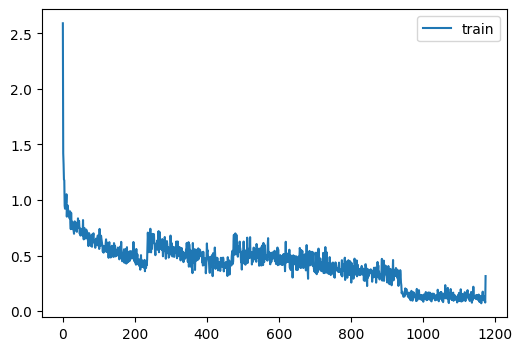

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


eplacing top 12600 expamples
eplacing top 25200 expamples
eplacing top 12600 expamples
Fit 5 in: 129.04s, setup: 0.00s, 24.58 ± 0.17s per epoch, 0.01 ± 0.00s per batch


In [36]:
set_seed(1)

dls = CustomDataLoader.from_dd(tds.cached, bs, num_workers=0)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, TopLossesCallback(), ProgressCB(plot=True), TrainCB()]
act_gr = Mish
iw = partial(init_weights, leaky=0.0003)
#0.0003 from https://github.com/digantamisra98/Mish/issues/37

epochs=5
lr=1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.939,0.176,0,eval


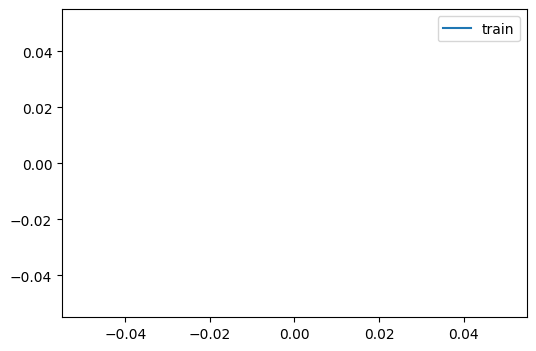

In [19]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.943,0.167,0,eval


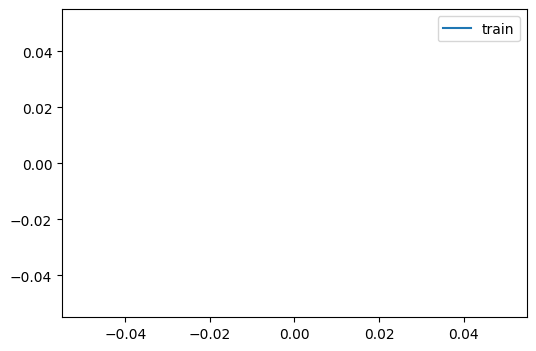

In [20]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [21]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.9442

## [93.92] 5ep with regular random sampler

accuracy,loss,epoch,train
0.831,0.640,0,train
0.851,0.456,0,eval
0.886,0.350,1,train
0.903,0.281,1,eval
0.914,0.255,2,train
0.901,0.276,2,eval
0.928,0.207,3,train
0.921,0.219,3,eval
0.943,0.164,4,train
0.935,0.187,4,eval


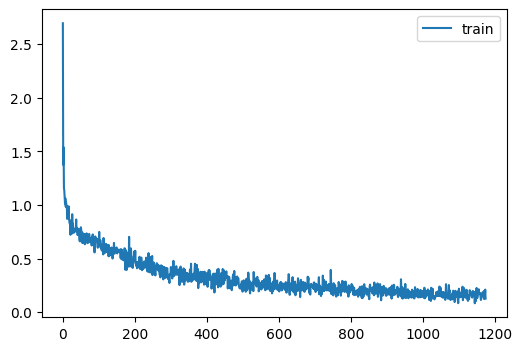

Fit 5 in: 129.79s, setup: 0.00s, 24.71 ± 0.04s per epoch, 0.01 ± 0.00s per batch


In [22]:
set_seed(1)

dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), TrainCB()]
act_gr = Mish
iw = partial(init_weights, leaky=0.0003)
#0.0003 from https://github.com/digantamisra98/Mish/issues/37

epoch=5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.935,0.187,0,eval


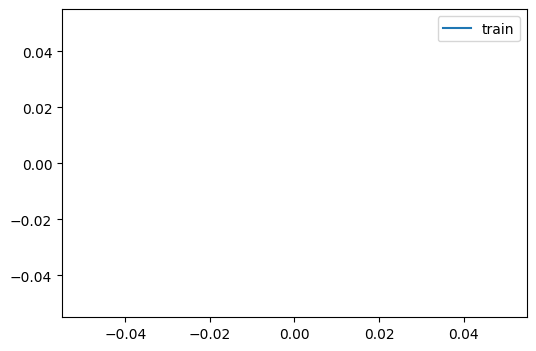

In [23]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.937,0.178,0,eval


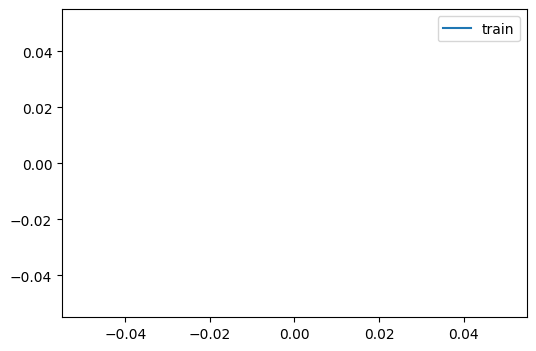

In [24]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [25]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.9392

In [38]:
import nbdev; nbdev.nbdev_export()